By Drilon & Chia-Hua

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

/home/shubuni/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Loading Data

In [39]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [40]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [41]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### Exercise 2: Fixed MLP with Increasing Training Dataset

Create a MLP with one hidden layer with 200 units for Fashion MNIST classification. Use ReLU activation.

Use a random fraction of the training set (split above) to perform the training. Always use the same validation set.

Use SGD and cross-entropy loss and suitable learning rate.

Start with a single small batch for training (batch size 8) and make sure that you can overfit, i.e. bring the training accuracy to 100%.

Then, gradually increase the training set. Let it grow until you obtain values for the training and the validation loss which no longer indicate overfitting. Use a fixed batch size (batchsize 32).

#### MLP Class

In [42]:
# define a method that provides an instance of an MLP which uses as a list of units per layer as input

def mlp(units = [28*28, 200, 10]):
    """
    Creates an instance of an MLP with layers as specified in the 'units'-list (list of integers).
    """
    input_size = units[0]
    hidden_size = units[1]
    output_size = units[2]
    
    model = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size)
        )
    return model
    # YOUR CODE HERE #

In [64]:
# create an instance and its summary

model = mlp()
from torchsummary import summary
#summary(model, (1,28,28))
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=200, bias=True)
  (2): ReLU()
  (3): Linear(in_features=200, out_features=10, bias=True)
)


#### Training Loop 

In [78]:
def train_eval(model, lr, nepochs, nbatch, training_data, validation_data):
    """
    Performs the training of a model with given learning rate (lr), 
    number of epochs (nepochs), batchsize (nbatch) and training and validation data.
    Suitable data loaders are instantiated for the training and validation datasets.
    Keep book about cost and accuracy (per epoch) for both training and validation set.
    """
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []


    # YOUR CODE HERE #
    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
    
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    test_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=False)
    
    for epoch in range(nepochs):
        acc, cost = 0.0, 0.0
        for batch, (X, Y) in enumerate(training_loader):
            pred = model(X)
            loss = cost_ce(pred, Y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            cost += loss.item()
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

        cost /= (len(training_loader.dataset)/nbatch)
        acc /= len(training_loader.dataset)
        
        cost_hist.append(cost)
        acc_hist.append(acc)
            
        acc_test, cost_test = 0.0, 0.0
        with torch.no_grad():
            for X, Y in test_loader:
                pred = model(X)
                cost_test += cost_ce(pred, Y)
                acc_test += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
        
        cost_test /= (len(test_loader.dataset)/nbatch)
        acc_test /= len(test_loader.dataset)
        
        cost_hist_test.append(cost_test)
        acc_hist_test.append(acc_test)
        
        print(f"Epoch: {epoch}: cost: {cost_hist[-1]}, acc: {acc_hist[-1]}, cost_test: {cost_hist_test[-1]}, acc_test: {acc_hist_test[-1]}")
            
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

#### First Training

Run a first training with only one small training batch (e.g. with a single batch of 64 samples). 
The small training set can be created by using the functionality `torch.utils.data.random_split` already used above. As validation set use the `validation_data` created above.  

This training run can be used to test whether the model and training loop are properly implemented. Explain why and in what sense it can be used as test.

This is something you can always do when training a model.

64 49936
Epoch: 0: cost: 2.3119757175445557, acc: 0.171875, cost_test: 2.2753565311431885, acc_test: 0.1938
Epoch: 1: cost: 2.134868860244751, acc: 0.375, cost_test: 2.2435178756713867, acc_test: 0.2378
Epoch: 2: cost: 2.0098683834075928, acc: 0.46875, cost_test: 2.2177493572235107, acc_test: 0.2526
Epoch: 3: cost: 1.904201865196228, acc: 0.46875, cost_test: 2.1903603076934814, acc_test: 0.2808
Epoch: 4: cost: 1.8058639764785767, acc: 0.53125, cost_test: 2.161062002182007, acc_test: 0.3063
Epoch: 5: cost: 1.712275743484497, acc: 0.546875, cost_test: 2.1264264583587646, acc_test: 0.3389
Epoch: 6: cost: 1.62461519241333, acc: 0.625, cost_test: 2.088754653930664, acc_test: 0.3564
Epoch: 7: cost: 1.5439475774765015, acc: 0.640625, cost_test: 2.047111988067627, acc_test: 0.3675
Epoch: 8: cost: 1.4695922136306763, acc: 0.65625, cost_test: 2.0029654502868652, acc_test: 0.3733
Epoch: 9: cost: 1.400230050086975, acc: 0.65625, cost_test: 1.9579726457595825, acc_test: 0.3761
Epoch: 10: cost: 1.33

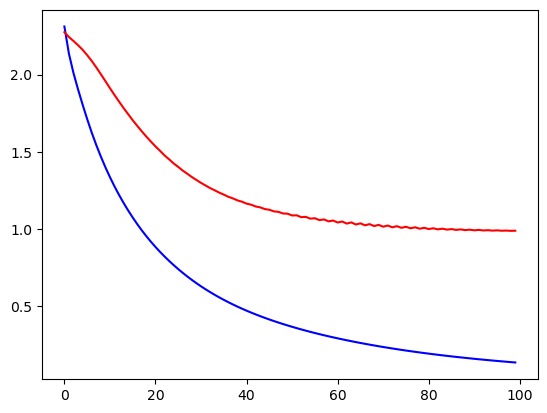

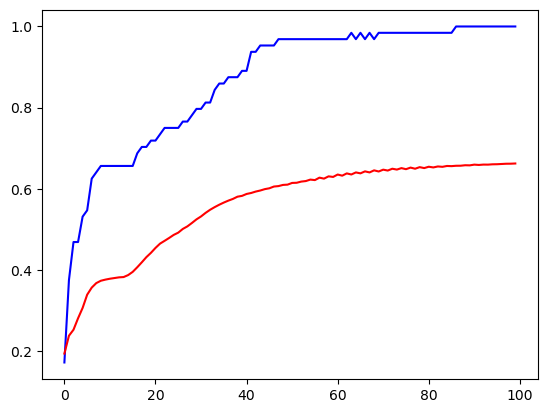

In [58]:
nbatch = 64
nbatches = 1
nepochs = 100
lr = 0.1

trainsize = nbatches*nbatch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
print(len(trainset), len(rest))

model = mlp([28*28, 200, 10])
cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data)

plt.figure(1)
plt.plot(range(nepochs), cost_train, "b-")
plt.plot(range(nepochs), cost_valid, "r-")

plt.figure(2)
plt.plot(range(nepochs), acc_train, "b-")
plt.plot(range(nepochs), acc_valid, "r-")

Already with a small number of epochs we can see if the model is able to learn, by checking that the cost decreases and accuracy increases. 
Because the number of epochs is kept relatively low, we can do this initial test quite fast.

#### Evaluate Train and Validation Performance 

Now run several trainings with the same small model (one hidden layer) and explore for different number of training samples (different number of batches with 32 samples) used, how the train and validation performance evolve (cost and accuracy). Make sure that you train sufficiently long to obtain representative values for cost and accuracy with the given settings. Always use the same validation set (with 10'000 samples).

Create plots with training and validation performance vs number of training batches (one for cost and one for accuracy). Use the performance characteristics obtained at the end.

Discuss the whether there is a sufficient number of training samples for the given problem at hand. Specify a minimum number if applicable. Also consider whether you are in the underfitting regime.

Hint: Specify a list with the number of training batches you would like to perform trainings. Try to be economic with the resources used - try to keep the number of trainings limited.

32 49968
Epoch: 0: cost: 2.3089187145233154, acc: 0.09375, cost_test: 2.2546346187591553, acc_test: 0.1188
Epoch: 1: cost: 2.154686212539673, acc: 0.28125, cost_test: 2.2209033966064453, acc_test: 0.1556
Epoch: 2: cost: 2.0519330501556396, acc: 0.375, cost_test: 2.1895346641540527, acc_test: 0.2232
Epoch: 3: cost: 1.9606420993804932, acc: 0.4375, cost_test: 2.1569981575012207, acc_test: 0.254
Epoch: 4: cost: 1.8737072944641113, acc: 0.46875, cost_test: 2.117424964904785, acc_test: 0.2709
Epoch: 5: cost: 1.7862133979797363, acc: 0.5, cost_test: 2.077024221420288, acc_test: 0.2918
Epoch: 6: cost: 1.698516607284546, acc: 0.5, cost_test: 2.0328521728515625, acc_test: 0.3174
Epoch: 7: cost: 1.6116048097610474, acc: 0.5, cost_test: 1.989559531211853, acc_test: 0.3336
Epoch: 8: cost: 1.5283550024032593, acc: 0.5625, cost_test: 1.9473702907562256, acc_test: 0.3512
Epoch: 9: cost: 1.44896399974823, acc: 0.59375, cost_test: 1.9044795036315918, acc_test: 0.3745
Epoch: 10: cost: 1.3755433559417725

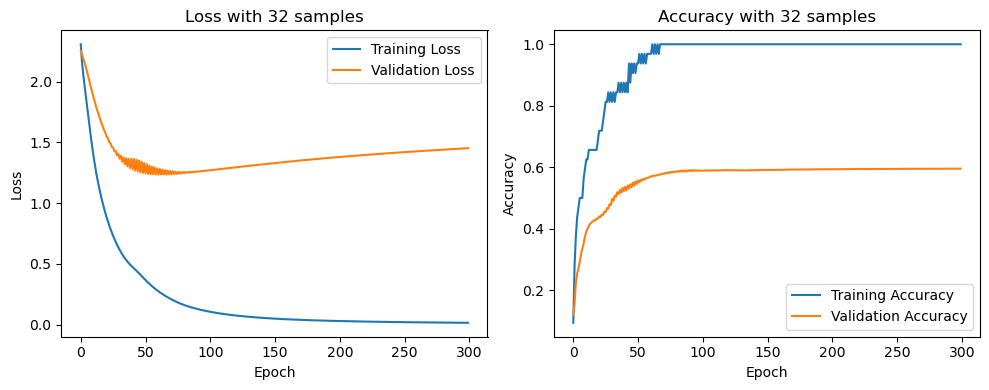

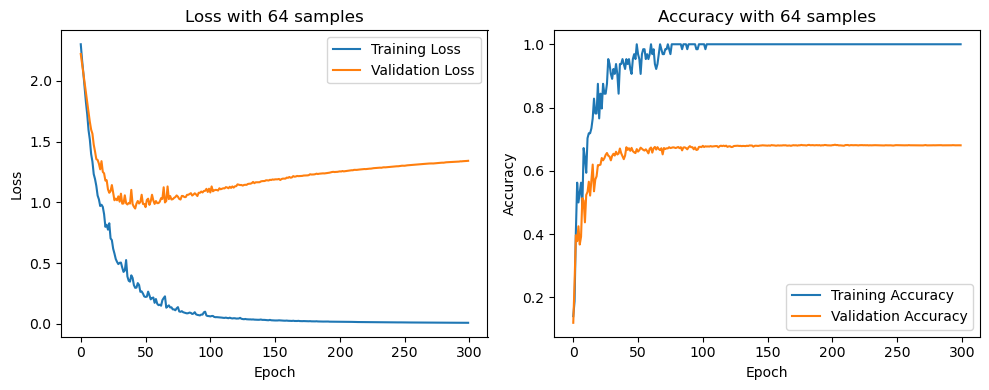

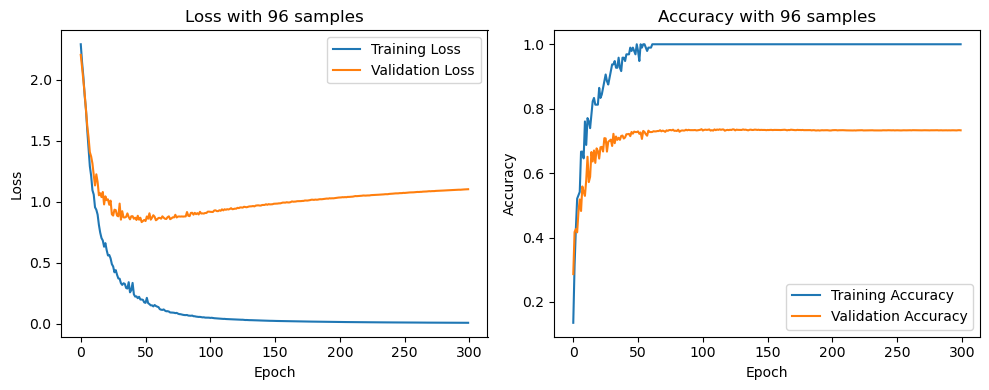

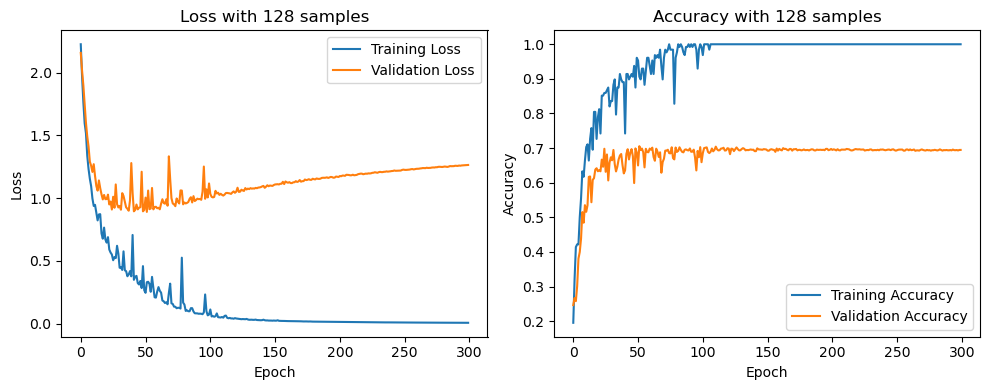

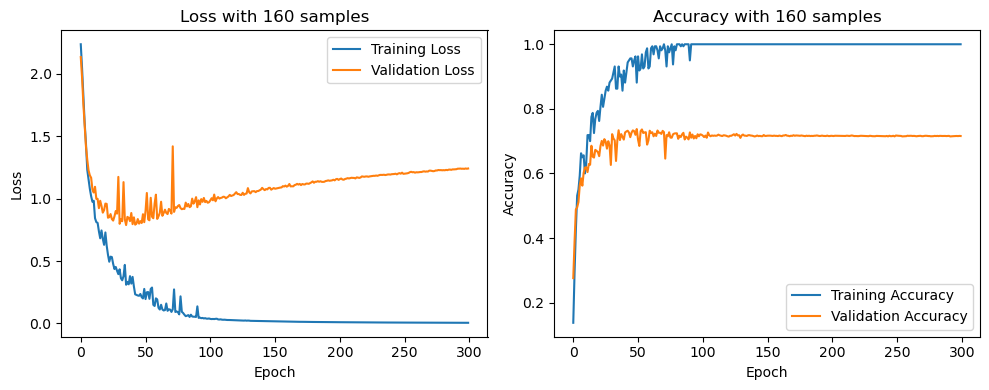

In [57]:
nbatch = 32
nepochs = 100
lr = 0.1

nbatches_tests = [1, 2, 3, 4, 5]
nbatches_results = {}

for nbatches in nbatches_tests:
    trainsize = nbatches*nbatch
    trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
    print(len(trainset), len(rest))
    
    model = mlp([28*28, 200, 10])
    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data)
    
    nbatches_results[nbatches] = (cost_train, cost_valid, acc_train, acc_valid)

for idx, result in enumerate(nbatches_results, start=1):
    cost_train, cost_valid, acc_train, acc_valid = nbatches_results[result]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Loss with {result * nbatch} samples")
    plt.plot(range(nepochs), cost_train, label="Training Loss")
    plt.plot(range(nepochs), cost_valid, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f"Accuracy with {result * nbatch} samples")
    plt.plot(range(nepochs), acc_train, label="Training Accuracy")
    plt.plot(range(nepochs), acc_valid, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

#### Comments
We are clearly in the overfitting region which is characterized by the discrepancy between the model's performance on the 
training data (1.0 after already ~100 epochs) and its limited performance on the unseen validation data (~0.7 at most). 

Therefore we don't think this is a question of sufficient number of training samples but more of the model architecture. To improve generalisation
and with this the validation accuracy, we could introduce regularization techniques, dropout and/or reduce model complexity.

Plots are stored in the /output directory.

### Exercise 3: Evaluate Different Model Complexities

Use the same functionality implemented above (create MLP model, train and evaluate model) to evaluate different model complexities: Number of layers and number of units per layer.

Start with the small model used in Exercise 2. Then gradually increase the model complexity. Do this along two dimensions:
* a single hidden layer, but increasing the number of units.
* a fixed number of units per (hidden) layer, but increase the number of layers.
Make sure that you reach the overfitting regime (in either case).

Always use the full training set with 50'000 samples.

Again make sure that you train sufficiently long so that the obtained train and validation performance measures (cost, accuracy) are representative.

Create plots with training and validation performance (cost, accuracy) vs model complexity - one plot with number of units for the single hidden layer case, and one for varying number of layers. 

Again use the performance characteristics obtained at the end. 

Finally, discuss your findings.

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=10, bias=True)
)
Epoch: 0: cost: 2.2951722145080566, acc: 0.09375, cost_test: 2.276588201522827, acc_test: 0.1034
Epoch: 1: cost: 2.214010238647461, acc: 0.21875, cost_test: 2.2605631351470947, acc_test: 0.1025
Epoch: 2: cost: 2.1553354263305664, acc: 0.1875, cost_test: 2.2409186363220215, acc_test: 0.103
Epoch: 3: cost: 2.0959651470184326, acc: 0.21875, cost_test: 2.225908041000366, acc_test: 0.1031
Epoch: 4: cost: 2.0324153900146484, acc: 0.1875, cost_test: 2.2039544582366943, acc_test: 0.1104
Epoch: 5: cost: 1.9606564044952393, acc: 0.21875, cost_test: 2.1865453720092773, acc_test: 0.1342
Epoch: 6: cost: 1.8901236057281494, acc: 0.21875, cost_test: 2.160329818725586, acc_test: 0.1717
Epoch: 7: cost: 1.8215131759643555, acc: 0.28125, cost_test: 2.143212080001831, acc_test: 0.1909
Epoch: 8: cost: 1.754132628440857, acc:

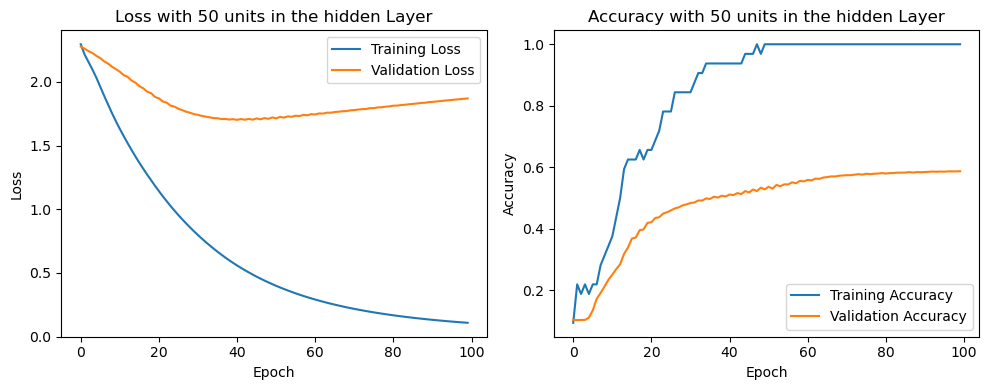

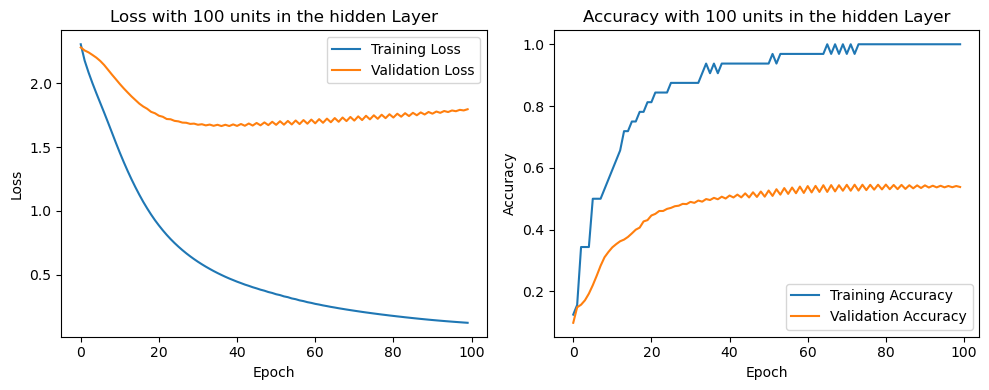

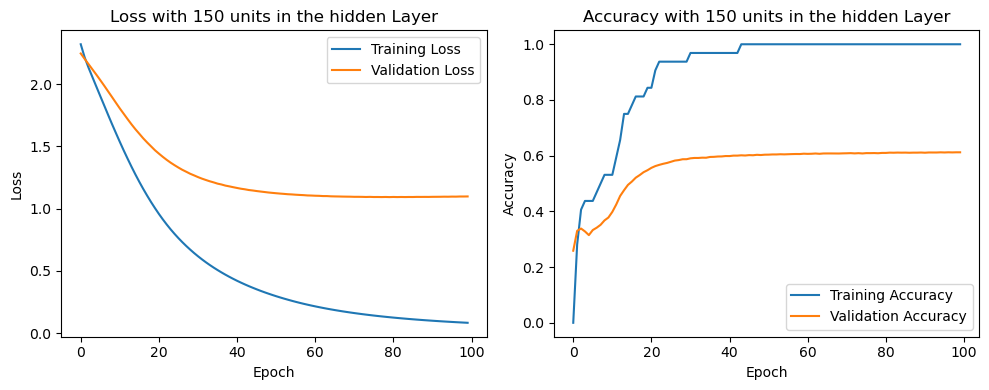

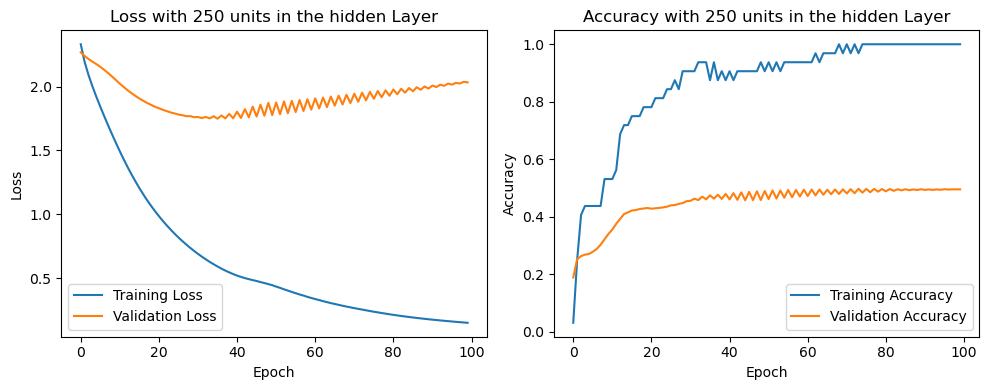

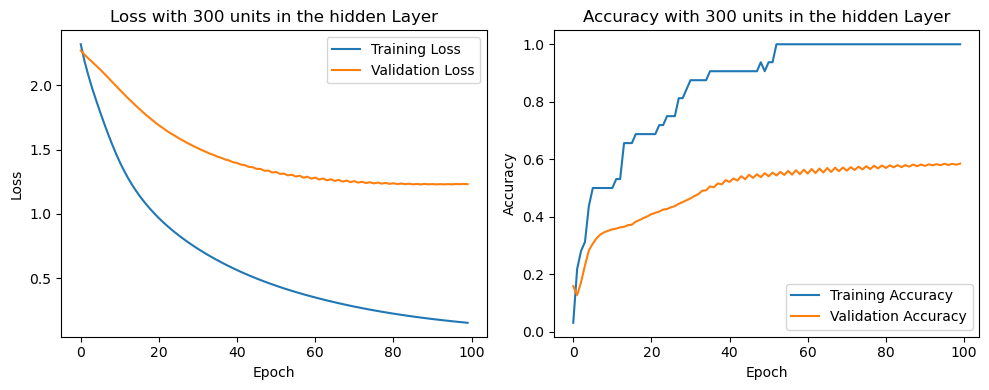

In [65]:
# YOUR CODE HERE #
# several iterations with the code snippets of the form:

nbatch = 32
nbatches = 1
nepochs = 100
lr = 0.1

nunits_test = [50, 100, 150, 250, 300]
nunits_test_results = {}

for units in nunits_test:
    trainsize = nbatches * nbatch
    trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000 - trainsize])

    model = mlp([28 * 28, units, 10])
    print(model)
    
    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data)

    nunits_test_results[units] = (cost_train, cost_valid, acc_train, acc_valid)

for idx, result in enumerate(nunits_test_results, start=1):
    cost_train, cost_valid, acc_train, acc_valid = nunits_test_results[result]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Loss with {result} units in the hidden Layer")
    plt.plot(range(nepochs), cost_train, label="Training Loss")
    plt.plot(range(nepochs), cost_valid, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f"Accuracy with {result} units in the hidden Layer")
    plt.plot(range(nepochs), acc_train, label="Training Accuracy")
    plt.plot(range(nepochs), acc_valid, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=200, bias=True)
  (2): ReLU()
  (3): Linear(in_features=200, out_features=200, bias=True)
  (4): ReLU()
  (5): Linear(in_features=200, out_features=10, bias=True)
)
Epoch: 0: cost: 2.325265407562256, acc: 0.0625, cost_test: 2.307600498199463, acc_test: 0.0898
Epoch: 1: cost: 2.298576831817627, acc: 0.0625, cost_test: 2.3019580841064453, acc_test: 0.1183
Epoch: 2: cost: 2.2756972312927246, acc: 0.3125, cost_test: 2.29653263092041, acc_test: 0.1778
Epoch: 3: cost: 2.2540972232818604, acc: 0.375, cost_test: 2.2910664081573486, acc_test: 0.1848
Epoch: 4: cost: 2.2330482006073, acc: 0.375, cost_test: 2.285580635070801, acc_test: 0.188
Epoch: 5: cost: 2.2113380432128906, acc: 0.375, cost_test: 2.279960870742798, acc_test: 0.1896
Epoch: 6: cost: 2.187973737716675, acc: 0.375, cost_test: 2.2740654945373535, acc_test: 0.1909
Epoch: 7: cost: 2.1620900630950928, acc: 0.375, cost_test: 2.267827987670898

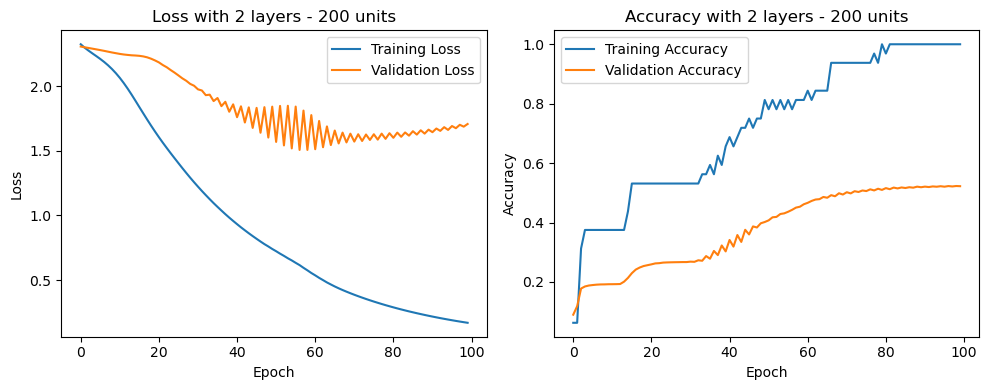

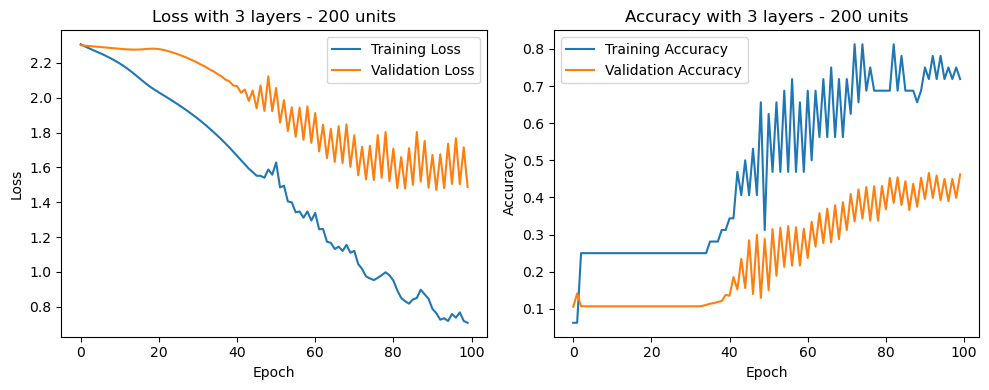

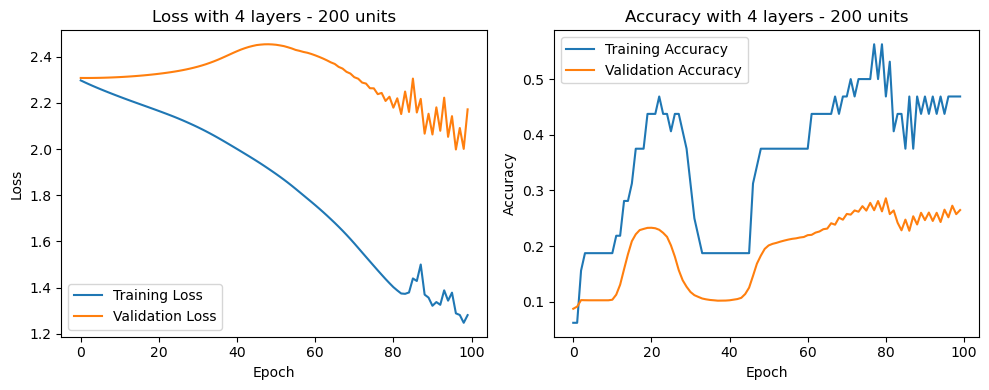

In [66]:
def flex_mlp_model(input_size, hidden_units, num_hidden_layers, output_size):
    layers = [torch.nn.Flatten()]
    last_size = input_size

    for _ in range(num_hidden_layers):
        layers.append(torch.nn.Linear(last_size, hidden_units))
        layers.append(torch.nn.ReLU())
        last_size = hidden_units

    layers.append(torch.nn.Linear(hidden_units, output_size))

    model = torch.nn.Sequential(*layers)
    return model

input_size = 28*28
hidden_units = 200
output_size = 10

nbatch = 32
nbatches = 1
nepochs = 100
lr = 0.1

num_hidden_layers_test = [2, 3, 4]
num_hidden_layers_results = {}

for num_hidden_layers in num_hidden_layers_test:
    trainsize = nbatches * nbatch
    trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000 - trainsize])

    model = flex_mlp_model(input_size, hidden_units, num_hidden_layers, output_size)
    print(model)

    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data)

    num_hidden_layers_results[num_hidden_layers] = (cost_train, cost_valid, acc_train, acc_valid)

for idx, result in enumerate(num_hidden_layers_results, start=1):
    cost_train, cost_valid, acc_train, acc_valid = num_hidden_layers_results[result]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Loss with {result} layers - 200 units")
    plt.plot(range(nepochs), cost_train, label="Training Loss")
    plt.plot(range(nepochs), cost_valid, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f"Accuracy with {result} layers - 200 units")
    plt.plot(range(nepochs), acc_train, label="Training Accuracy")
    plt.plot(range(nepochs), acc_valid, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

#### Comments
Increasing the number of units didn't improve the models capability to generalise, on the contrary the validation accuracy got even worse.
Interestingly the same happened to a low number of units. Around 200 units in one layer seems to work good for this example.

By changing the number of layers with a fixed amount of units (200) the training and validation got way more unstable, as can be seen by the high
variance in the plots. Maybe changing the batch size together with the number of layers would have been an interesting technique to achieve a 
better performing model.

Plots are stored in the /output directory.

### Exercise 4: Add Regularisation

Finally, add regularisation - dropout or L1/L2-regularisation. 

To this end, you need to implement new functionality to instantiate the model.

Start with one of the overfitting cases of Exercise 3 and try to improve the validation performance by adding regularisation. You can use either dropout or L1/L2-regularisation.


In [67]:
# define a method that provides an instance of an MLP incl regularisation which uses as a list of units per layer as input 

def mlp_dropout(units = [28*28, 200, 10], p_in = 0.2, p_hidden=0.5):
    """
    Creates an instance of an MLP with layers as specified in the 'units'-list (list of integers) and dropout 
    regularisation. Dropout rate for all layers the same except for the first (p_in). For the output layer 
    no dropout applied. 
    """
    layers = [torch.nn.Flatten(), torch.nn.Dropout(p_in)]
    
    for i in range(1, len(units) - 1):
        layers.append(torch.nn.Linear(units[i-1], units[i]))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Dropout(p_hidden))

    layers.append(torch.nn.Linear(units[1], units[2]))

    model = torch.nn.Sequential(*layers)
    return model

In [68]:
model = mlp_dropout([28*28,200,10])

from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 200]         157,000
              ReLU-4                  [-1, 200]               0
           Dropout-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.61
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


#### Playing with different complexities and regularisation

Now play with different complexities and regularisation. 
Start with one of the overfitting cases identified in the previous exercise.
By adding regularisation, you should be able to make it non-overfitting, i.e. generalising better.
Note that for a given complexity, adding regularisation reduces the model capacity. This may need to be compensated by increasing the complexity of the model. 

Use again cost and accuracy for train and validation set to evaluate the results.

Finally, estimate the bias error and the generalisation error. 

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Dropout(p=0.2, inplace=False)
  (2): Linear(in_features=784, out_features=200, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.2, inplace=False)
  (5): Linear(in_features=200, out_features=10, bias=True)
)
Epoch: 0: cost: 2.2868382930755615, acc: 0.15625, cost_test: 2.2580602169036865, acc_test: 0.1524
Epoch: 1: cost: 2.167133331298828, acc: 0.21875, cost_test: 2.2303006649017334, acc_test: 0.1728
Epoch: 2: cost: 2.1009459495544434, acc: 0.34375, cost_test: 2.207042694091797, acc_test: 0.1702
Epoch: 3: cost: 2.028499126434326, acc: 0.3125, cost_test: 2.1820380687713623, acc_test: 0.192
Epoch: 4: cost: 1.9718226194381714, acc: 0.34375, cost_test: 2.162238359451294, acc_test: 0.1804
Epoch: 5: cost: 1.88765287399292, acc: 0.4375, cost_test: 2.1394078731536865, acc_test: 0.2102
Epoch: 6: cost: 1.8538131713867188, acc: 0.40625, cost_test: 2.110112190246582, acc_test: 0.2374
Epoch: 7: cost: 1.8038618564605713, acc: 0.5, cost_test: 2.0870

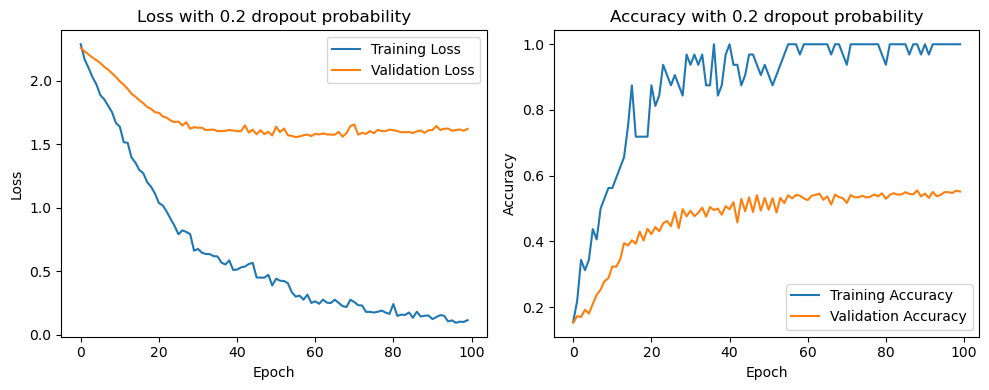

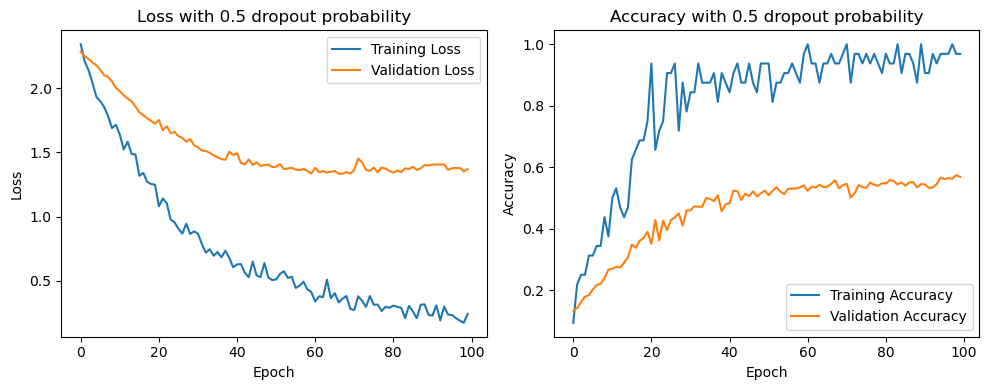

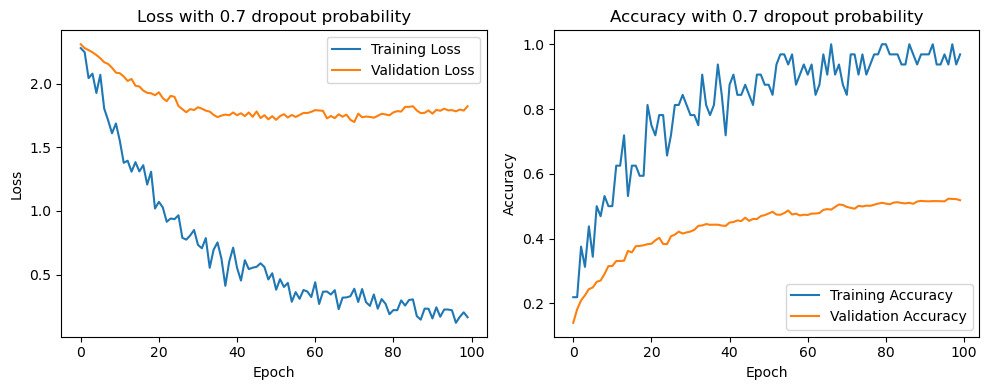

In [71]:
nbatch = 32
nbatches = 1
nepochs = 100
lr = 0.1

p_hidden_test = [0.2, 0.5, 0.7]
p_hidden_results = {}

for p_hidden in p_hidden_test:
    trainsize = nbatches * nbatch
    trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000 - trainsize])

    model = mlp_dropout(p_hidden=p_hidden)
    print(model)

    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data)

    p_hidden_results[p_hidden] = (cost_train, cost_valid, acc_train, acc_valid)

for idx, result in enumerate(p_hidden_results, start=1):
    cost_train, cost_valid, acc_train, acc_valid = p_hidden_results[result]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Loss with {result} dropout probability")
    plt.plot(range(nepochs), cost_train, label="Training Loss")
    plt.plot(range(nepochs), cost_valid, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f"Accuracy with {result} dropout probability")
    plt.plot(range(nepochs), acc_train, label="Training Accuracy")
    plt.plot(range(nepochs), acc_valid, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Dropout(p=0.2, inplace=False)
  (2): Linear(in_features=784, out_features=200, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.2, inplace=False)
  (5): Linear(in_features=200, out_features=200, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=200, out_features=200, bias=True)
)
Epoch: 0: cost: 5.194204807281494, acc: 0.07291666666666667, cost_test: 5.076189994812012, acc_test: 0.1507
Epoch: 1: cost: 4.902043183644612, acc: 0.15625, cost_test: 4.541813850402832, acc_test: 0.116
Epoch: 2: cost: 3.8988710244496665, acc: 0.14583333333333334, cost_test: 3.324737787246704, acc_test: 0.1244
Epoch: 3: cost: 2.9570836226145425, acc: 0.21875, cost_test: 3.088505744934082, acc_test: 0.1152
Epoch: 4: cost: 2.9510042667388916, acc: 0.17708333333333334, cost_test: 2.9738073348999023, acc_test: 0.1268
Epoch: 5: cost: 2.7489813963572183, acc: 0.15625, cost_test: 2.584583044052124, acc_test: 0.2147
Epoch: 6: c

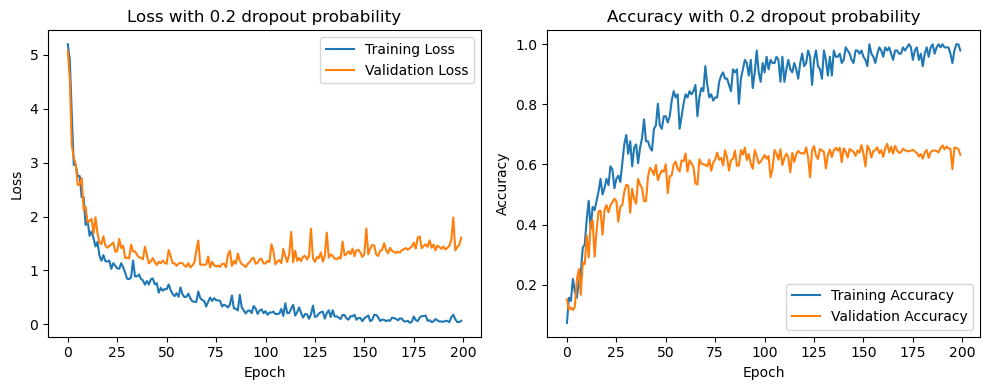

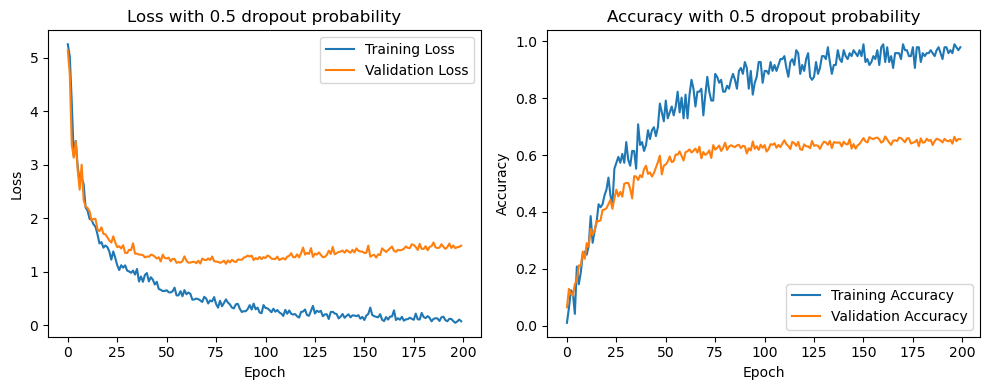

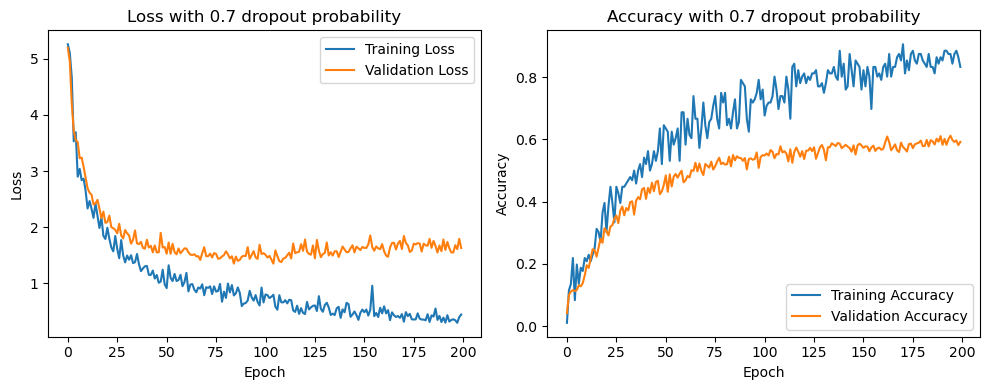

In [79]:
nbatch = 32
nbatches = 3
nepochs = 200
lr = 0.1

p_hidden_test = [0.2, 0.5, 0.7]
p_hidden_results = {}

for p_hidden in p_hidden_test:
    trainsize = nbatches * nbatch
    trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000 - trainsize])

    model = mlp_dropout(units=[28*28, 200, 200, 10], p_hidden=p_hidden)
    print(model)

    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data)

    p_hidden_results[p_hidden] = (cost_train, cost_valid, acc_train, acc_valid)

for idx, result in enumerate(p_hidden_results, start=1):
    cost_train, cost_valid, acc_train, acc_valid = p_hidden_results[result]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Loss with {result} dropout probability")
    plt.plot(range(nepochs), cost_train, label="Training Loss")
    plt.plot(range(nepochs), cost_valid, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f"Accuracy with {result} dropout probability")
    plt.plot(range(nepochs), acc_train, label="Training Accuracy")
    plt.plot(range(nepochs), acc_valid, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [82]:
def train_eval(model, lr, nepochs, nbatch, training_data, validation_data):
    """
    Performs the training of a model with given learning rate (lr), 
    number of epochs (nepochs), batchsize (nbatch) and training and validation data.
    Suitable data loaders are instantiated for the training and validation datasets.
    Keep book about cost and accuracy (per epoch) for both training and validation set.
    """
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []


    # YOUR CODE HERE #
    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)  # added weight decay for L2 regularization

    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    test_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=False)

    for epoch in range(nepochs):
        acc, cost = 0.0, 0.0
        for batch, (X, Y) in enumerate(training_loader):
            pred = model(X)
            loss = cost_ce(pred, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cost += loss.item()
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

        cost /= (len(training_loader.dataset)/nbatch)
        acc /= len(training_loader.dataset)

        cost_hist.append(cost)
        acc_hist.append(acc)

        acc_test, cost_test = 0.0, 0.0
        with torch.no_grad():
            for X, Y in test_loader:
                pred = model(X)
                cost_test += cost_ce(pred, Y)
                acc_test += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

        cost_test /= (len(test_loader.dataset)/nbatch)
        acc_test /= len(test_loader.dataset)

        cost_hist_test.append(cost_test)
        acc_hist_test.append(acc_test)

        print(f"Epoch: {epoch}: cost: {cost_hist[-1]}, acc: {acc_hist[-1]}, cost_test: {cost_hist_test[-1]}, acc_test: {acc_hist_test[-1]}")

    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Dropout(p=0.2, inplace=False)
  (2): Linear(in_features=784, out_features=200, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.2, inplace=False)
  (5): Linear(in_features=200, out_features=200, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=200, out_features=200, bias=True)
)
Epoch: 0: cost: 5.278804620107015, acc: 0.03125, cost_test: 5.234153747558594, acc_test: 0.0867
Epoch: 1: cost: 5.155112107594808, acc: 0.125, cost_test: 5.108088493347168, acc_test: 0.1103
Epoch: 2: cost: 4.956313292185466, acc: 0.16666666666666666, cost_test: 4.8610968589782715, acc_test: 0.1036
Epoch: 3: cost: 4.561898708343506, acc: 0.14583333333333334, cost_test: 4.345444202423096, acc_test: 0.1023
Epoch: 4: cost: 3.8577258586883545, acc: 0.14583333333333334, cost_test: 3.702542543411255, acc_test: 0.1081
Epoch: 5: cost: 3.1855475902557373, acc: 0.25, cost_test: 3.189798593521118, acc_test: 0.1081
Epoch: 6: cost: 2

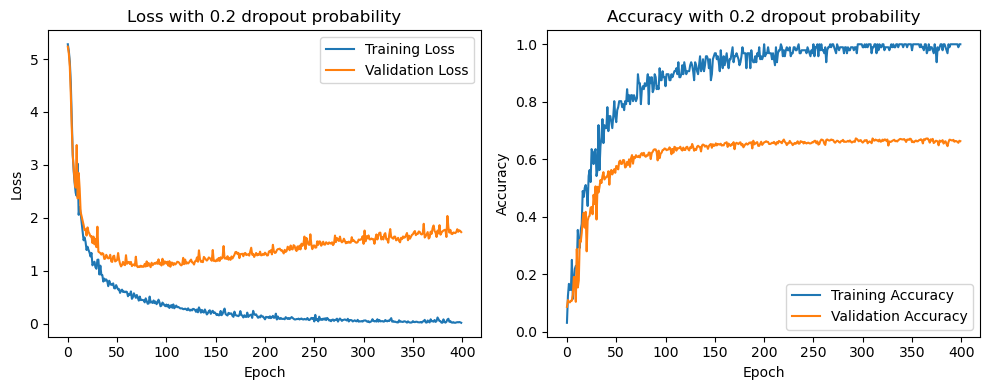

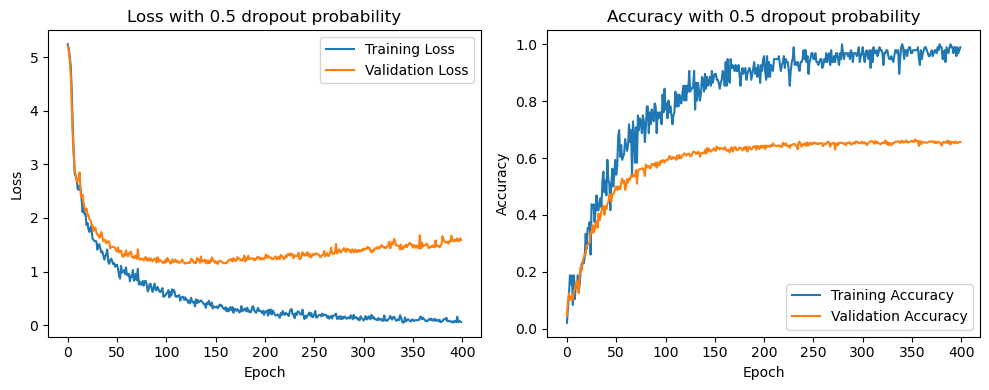

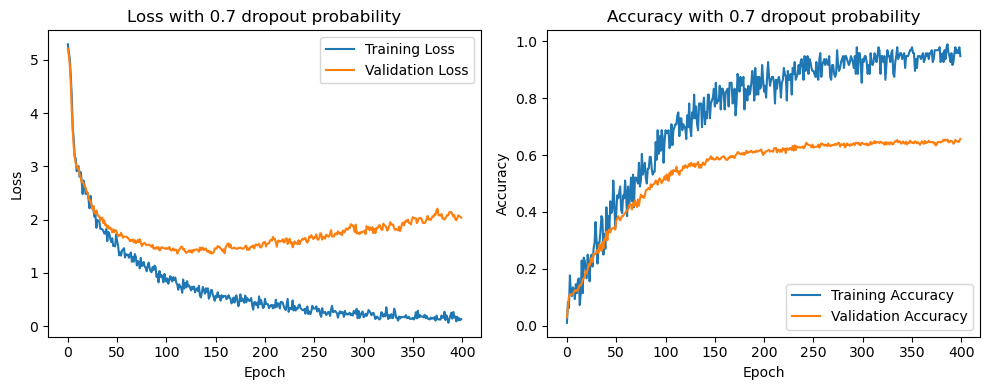

In [83]:
nbatch = 32
nbatches = 3
nepochs = 400
lr = 0.05

p_hidden_test = [0.2, 0.5, 0.7]
p_hidden_results = {}

for p_hidden in p_hidden_test:
    trainsize = nbatches * nbatch
    trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000 - trainsize])

    model = mlp_dropout(units=[28*28, 200, 200, 10], p_hidden=p_hidden)
    print(model)

    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data)

    p_hidden_results[p_hidden] = (cost_train, cost_valid, acc_train, acc_valid)

for idx, result in enumerate(p_hidden_results, start=1):
    cost_train, cost_valid, acc_train, acc_valid = p_hidden_results[result]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Loss with {result} dropout probability")
    plt.plot(range(nepochs), cost_train, label="Training Loss")
    plt.plot(range(nepochs), cost_valid, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f"Accuracy with {result} dropout probability")
    plt.plot(range(nepochs), acc_train, label="Training Accuracy")
    plt.plot(range(nepochs), acc_valid, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

- Bias Error refers to the error due to overly simplistic assumptions in the learning algorithm. High bias can cause the model to miss relevant relations between features and target outputs (underfitting).
- Generalization Error (or test error) measures how well your model performs on unseen data. It's the difference between the error on the training dataset and the error on the entire population of data or an unseen test set.

High training loss and low accuracy indicate high bias and on the other hand a large difference between training and test metrics indicates high generalization error. Which indeed is the case here, even after attempts to minimize overfitting.